In [117]:
import mlflow 

run = mlflow.get_run(run_id='64111414e2de488ab47218ed8cd8b98f')

In [118]:
def find_test_sources(run):
    
    test_sources = {}

    for param_key in run.data.params:
        if 'arguseyes.test_source' in param_key:
            source_index = param_key.split('.')[2]
            detail = param_key.split('.')[3]

            if not source_index in test_sources:
                test_sources[source_index] = {}

            test_sources[source_index][detail] = run.data.params[param_key]

    return test_sources        

In [119]:
def fairness_criteria(run):
    criteria = set()
    for key in run.data.metrics:
        if key.startswith('arguseyes.fairness') and not '.not.' in key:
            criterion = (key.split('.')[2], key.split('.')[3])
            criteria.add(criterion) 
    return criteria                

def confusion_matrices_for_groups(run):
    import pandas as pd
    
    criteria = fairness_criteria(run) 

    records = []

    for sensitive_attribute, privileged_class in criteria:
        for score in ['true_negatives', 'false_positives', 'false_negatives', 'true_positives']:
            count_priv = \
                run.data.metrics[f'arguseyes.fairness.{sensitive_attribute}.{privileged_class}.{score}']
            count_dis = \
                run.data.metrics[f'arguseyes.fairness.{sensitive_attribute}.not.{privileged_class}.{score}']

            records.append((sensitive_attribute, privileged_class, score, count_priv, count_dis))       

    columns = ['sensitive_attribute', 'privileged_class','score', 'count_privileged', 'count_disadvantaged']
    confusion_matrices = pd.DataFrame.from_records(records, columns=columns)
    
    return confusion_matrices

In [120]:
find_test_sources(run)

{'6': {'attributes': "['race_id', 'race']",
  'num_records': '5',
  'type': 'SourceType.SIDE_DATA',
  'attribute_types': "['int64', 'object']"},
 '2': {'attribute_types': "['int64', 'object']",
  'num_records': '8',
  'attributes': "['workclass_id', 'workclass']",
  'type': 'SourceType.SIDE_DATA'},
 '1': {'type': 'SourceType.ENTITIES',
  'attributes': "['workclass_id', 'education_id', 'occupation_id', 'sex_id', 'race_id', 'age', 'capital-gain', 'capital-loss', 'hours-per-week', 'income-per-year']",
  'attribute_types': "['float64', 'int64', 'float64', 'int64', 'int64', 'int64', 'int64', 'int64', 'int64', 'object']",
  'num_records': '16281'},
 '3': {'num_records': '16',
  'attributes': "['education_id', 'education']",
  'attribute_types': "['int64', 'object']",
  'type': 'SourceType.SIDE_DATA'},
 '5': {'attribute_types': "['int64', 'object']",
  'num_records': '2',
  'type': 'SourceType.SIDE_DATA',
  'attributes': "['sex_id', 'sex']"},
 '4': {'attributes': "['occupation_id', 'occupatio

In [121]:
fairness_criteria(run)

{('race', 'white'), ('sex', 'male')}

In [122]:
confusion_matrices_for_groups(run)

,sensitive_attribute,privileged_class,score,count_privileged,count_disadvantaged
0,sex,male,true_negatives,812.0,427.0
1,sex,male,false_positives,167.0,115.0
2,sex,male,false_negatives,205.0,148.0
3,sex,male,true_positives,180.0,144.0
4,race,white,true_negatives,947.0,292.0
5,race,white,false_positives,224.0,58.0
6,race,white,false_negatives,294.0,59.0
7,race,white,true_positives,272.0,52.0


In [123]:
def fairness_metrics(run, sensitive_attribute, privileged_class):
    tp_priv = run.data.metrics[f'arguseyes.fairness.{sensitive_attribute}.{privileged_class}.true_positives']
    fn_priv = run.data.metrics[f'arguseyes.fairness.{sensitive_attribute}.{privileged_class}.false_negatives']
    tn_priv = run.data.metrics[f'arguseyes.fairness.{sensitive_attribute}.{privileged_class}.true_negatives']
    fp_priv = run.data.metrics[f'arguseyes.fairness.{sensitive_attribute}.{privileged_class}.false_positives']

    tp_dis = run.data.metrics[f'arguseyes.fairness.{sensitive_attribute}.not.{privileged_class}.true_positives']
    fn_dis = run.data.metrics[f'arguseyes.fairness.{sensitive_attribute}.not.{privileged_class}.false_negatives']
    tn_dis = run.data.metrics[f'arguseyes.fairness.{sensitive_attribute}.not.{privileged_class}.true_negatives']
    fp_dis = run.data.metrics[f'arguseyes.fairness.{sensitive_attribute}.not.{privileged_class}.false_positives']

    # tp / tp + fp
    predictive_parity = (tp_priv / (tp_priv + fp_priv)) - (tp_dis / (tp_dis + fp_dis))

    # tp / tp + fn
    equal_opportunity = (tp_priv / (tp_priv + fn_priv)) - (tp_dis / (tp_dis + fn_dis))

    # tp + fp / tp + fp + tn + fn
    statistical_parity = ((tp_priv + fp_priv) / (tp_priv + fn_priv + fp_priv + tn_priv)) \
        - ((tp_dis + fp_dis) / (tp_dis + fn_dis + fp_dis + tn_dis))

    return {
        'predictive_parity': predictive_parity, 
        'equal_opportunity': equal_opportunity, 
        'statistical_parity': statistical_parity
    }

In [124]:
fairness_metrics(run, 'sex', 'male')

{'predictive_parity': -0.03725256751193351,
 'equal_opportunity': -0.0256182173990393,
 'statistical_parity': -0.05615273177352548}

In [125]:
fairness_metrics(run, 'race', 'white')

{'predictive_parity': 0.07565982404692079,
 'equal_opportunity': 0.012096902556266498,
 'statistical_parity': 0.046938084837222754}

In [126]:
def plot_fairness_metrics(run, sensitive_attribute, non_protected_class):

    import matplotlib.pyplot as plt
    import numpy as np

    metrics = fairness_metrics(run, sensitive_attribute, non_protected_class)

    max_value = np.max(np.absolute(list(metrics.values())))

    plt.ylim((-max_value * 1.25, max_value * 1.25))

    plt.bar(np.arange(3), [metrics['predictive_parity'], metrics['equal_opportunity'], metrics['statistical_parity']])

    plt.xticks(np.arange(3), ['predictive parity', 'equal opportunity', 'statistical parity'])

    plt.show()

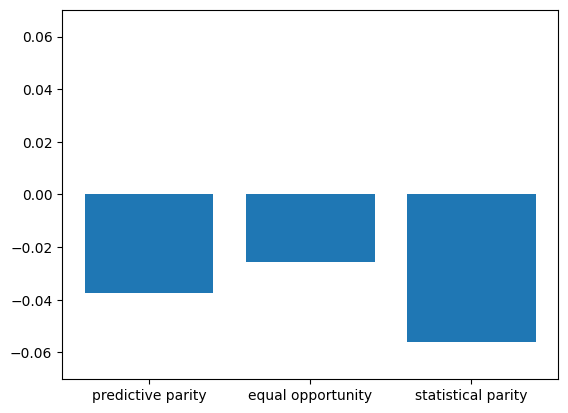

In [127]:
plot_fairness_metrics(run, 'sex', 'male')

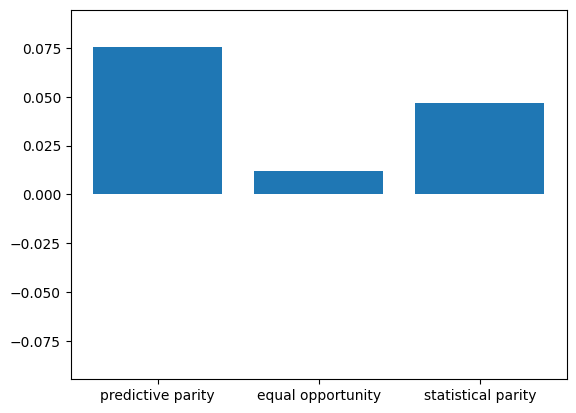

In [128]:
plot_fairness_metrics(run, 'race', 'white')